# Tensor flow GAN on Hband Galaxy cutouts

Last edited by Shooby: May 31, 2019

Read in CANDELS cutout images of galaxies as tensors with Tensorflow and feed that into a GAN. I have changed the input data much to be similar to MNIST in format. The discriminator and generator are copied from the MNIST examples mostly from JonBruner github on GANs, and some from Hvass-labs tutorials of tensorflow. No keras used in this notebook, directly tensorflow. Also, this uses convolutional nn but I am not sure yet, if it counts as a DCGAN or a simple GAN with all nodes connected.

In [1]:
from __future__ import print_function
import tensorflow as tf
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Loading Sample Galaxy data (with MNIST function):

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("")

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Instructions for updating:
Please use urllib or similar directly.


W0610 18:00:13.699940 4663567808 deprecation.py:323] From /Users/shemmati/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please use urllib or similar directly.


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting t10k-labels-idx1-ubyte.gz


ValueError: Validation size should be between 0 and 4000. Received: 5000.

In [3]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

(1, 784)


(1, 784)


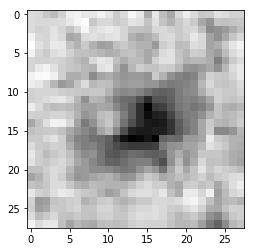

In [4]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image1 = sample_image.reshape([28, 28])
plt.imshow(sample_image1, cmap='Greys')

## The Discriminator and Generator (using simple CNNs)

A neural network with Tensor flow needs: 
    - placeholders for input data and labels (remember to normalize data before training)
    - model variables (weights and biases) 
    - a model (logit) (use a tanh before the output so output is also normalize)
    - a cost function
    - a cost optimization method (Adam is known to be better than stochastic GD)
after all the above is defined, a graph of the tensorflow is built. And a session to run the tensorflow can start

In [5]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [6]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [7]:
tf.reset_default_graph()
batch_size = 30

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
Dx = discriminator(x_placeholder) 

z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
Gz = generator(z_placeholder, batch_size, z_dimensions) 
Dg = discriminator(Gz, reuse_variables=True)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
#defining the cost (loss) functions: 
    
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [9]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

dLossReal: 0.6935245 dLossFake: 0.720573
dLossReal: 0.36432648 dLossFake: 0.44436845
dLossReal: 0.2390151 dLossFake: 0.09184105
Iteration: 0 at 2019-06-07 15:45:28.898727


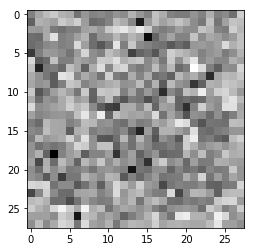

Estimate: [[-5.524238]]
Iteration: 50 at 2019-06-07 15:45:48.503881


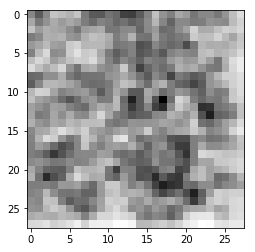

Estimate: [[-6.8664556]]
Iteration: 100 at 2019-06-07 15:46:07.327369


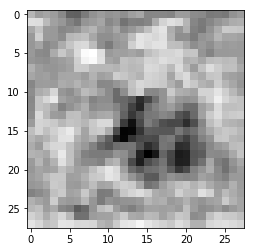

Estimate: [[-12.071957]]
Iteration: 150 at 2019-06-07 15:46:24.027505


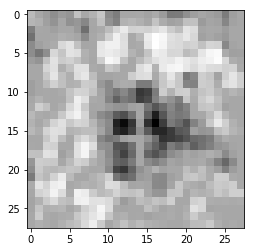

Estimate: [[-6.581322]]
Iteration: 200 at 2019-06-07 15:46:42.441819


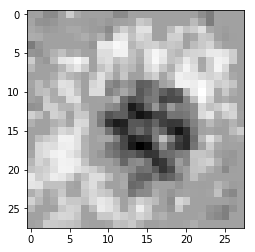

Estimate: [[-7.600321]]
Iteration: 250 at 2019-06-07 15:46:59.693794


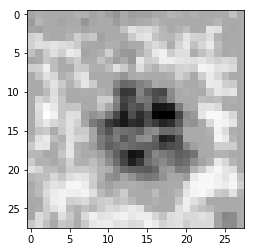

Estimate: [[-6.112944]]
Iteration: 300 at 2019-06-07 15:47:17.495748


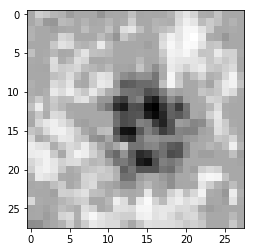

Estimate: [[-7.958996]]
Iteration: 350 at 2019-06-07 15:47:34.100772


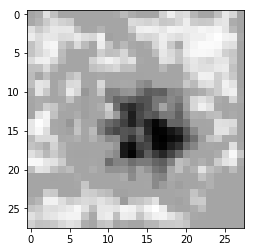

Estimate: [[-4.2478957]]
Iteration: 400 at 2019-06-07 15:47:50.947094


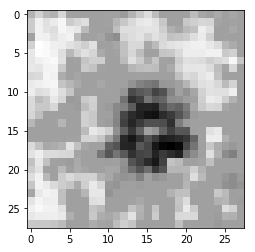

Estimate: [[-5.9851465]]
Iteration: 450 at 2019-06-07 15:48:08.096624


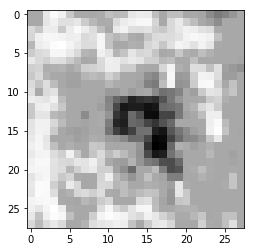

Estimate: [[-7.5917997]]
Iteration: 500 at 2019-06-07 15:48:26.012314


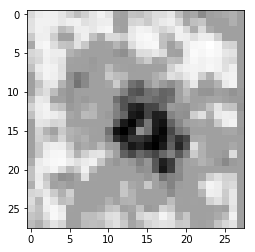

Estimate: [[-5.807891]]
Iteration: 550 at 2019-06-07 15:48:43.096640


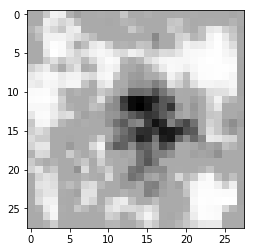

Estimate: [[-8.060486]]
Iteration: 600 at 2019-06-07 15:49:00.083174


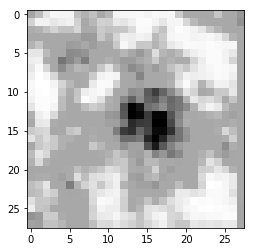

Estimate: [[-5.553828]]
Iteration: 650 at 2019-06-07 15:49:17.793180


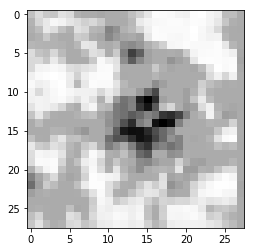

Estimate: [[-5.820602]]
Iteration: 700 at 2019-06-07 15:49:36.123083


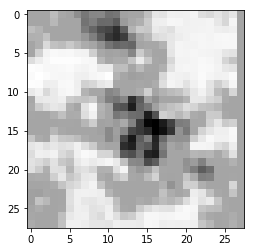

Estimate: [[-4.5271254]]
Iteration: 750 at 2019-06-07 15:49:53.788950


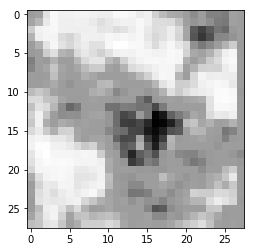

Estimate: [[-3.9863784]]
Iteration: 800 at 2019-06-07 15:50:11.327854


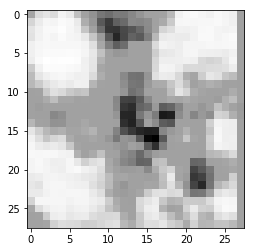

Estimate: [[-5.0099096]]
Iteration: 850 at 2019-06-07 15:50:29.208678


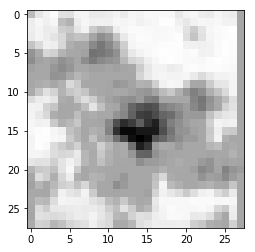

Estimate: [[-4.364387]]
Iteration: 900 at 2019-06-07 15:50:46.994867


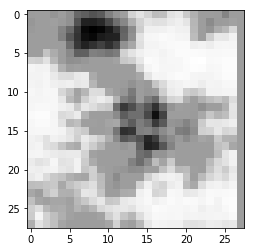

Estimate: [[-4.934227]]
Iteration: 950 at 2019-06-07 15:51:04.669388


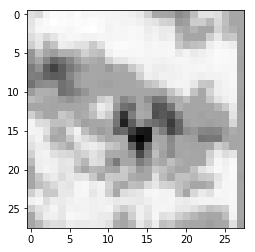

Estimate: [[-4.917095]]
Iteration: 1000 at 2019-06-07 15:51:21.478946


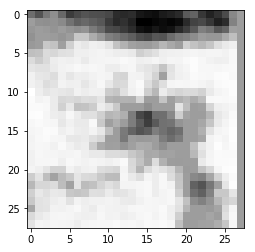

Estimate: [[-4.901731]]
Iteration: 1050 at 2019-06-07 15:51:38.222201


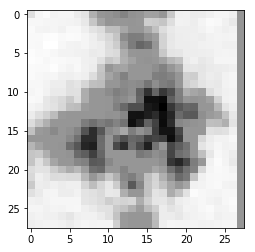

Estimate: [[-2.7342112]]
Iteration: 1100 at 2019-06-07 15:51:54.858239


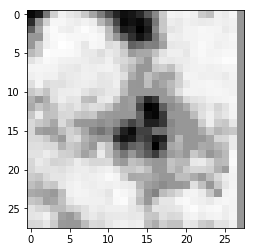

Estimate: [[-4.035552]]
Iteration: 1150 at 2019-06-07 15:52:11.615202


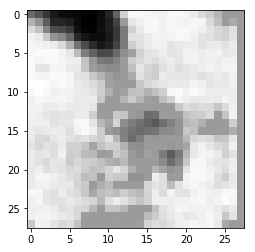

Estimate: [[-3.9802904]]
Iteration: 1200 at 2019-06-07 15:52:28.174683


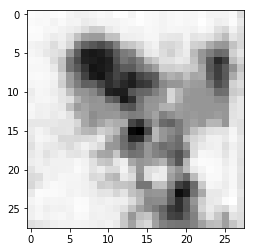

Estimate: [[-2.465394]]
Iteration: 1250 at 2019-06-07 15:52:44.912014


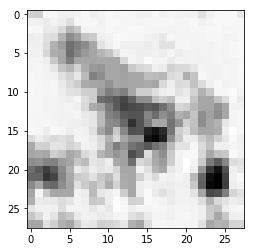

Estimate: [[-5.0467954]]
Iteration: 1300 at 2019-06-07 15:53:02.125176


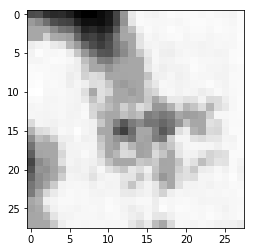

Estimate: [[-3.1925945]]
Iteration: 1350 at 2019-06-07 15:53:19.105631


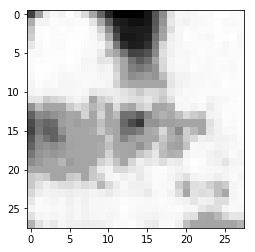

Estimate: [[-3.341105]]
Iteration: 1400 at 2019-06-07 15:53:36.107923


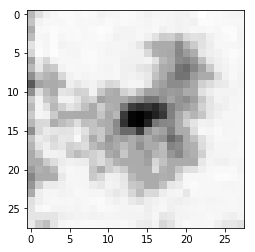

Estimate: [[-2.1996589]]
Iteration: 1450 at 2019-06-07 15:53:52.792059


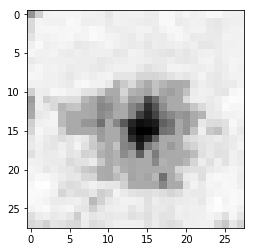

Estimate: [[-2.3940127]]
Iteration: 1500 at 2019-06-07 15:54:10.782066


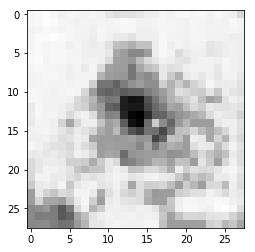

Estimate: [[-2.5258856]]
Iteration: 1550 at 2019-06-07 15:54:27.361532


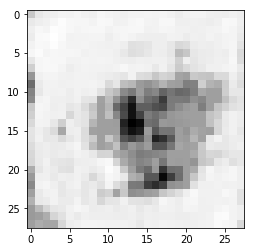

Estimate: [[-2.6024158]]
Iteration: 1600 at 2019-06-07 15:54:43.963544


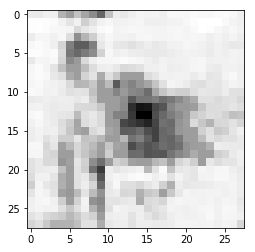

Estimate: [[-1.9907779]]
Iteration: 1650 at 2019-06-07 15:55:00.856749


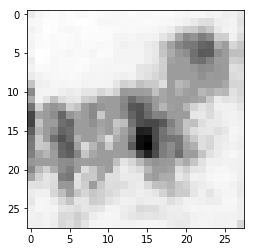

Estimate: [[-1.3996651]]
Iteration: 1700 at 2019-06-07 15:55:17.806946


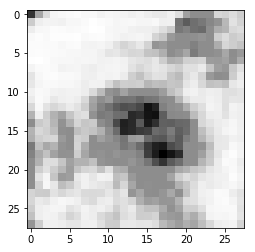

Estimate: [[-2.2512906]]
Iteration: 1750 at 2019-06-07 15:55:34.280218


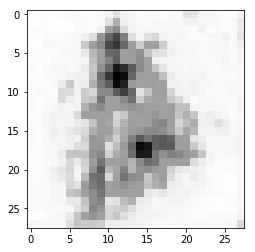

Estimate: [[-1.9038804]]
Iteration: 1800 at 2019-06-07 15:55:51.300880


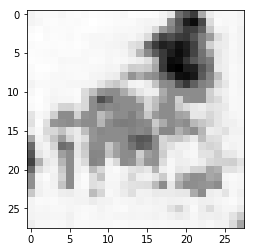

Estimate: [[-1.6581614]]
Iteration: 1850 at 2019-06-07 15:56:07.854869


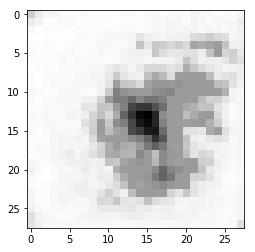

Estimate: [[-2.5489209]]
Iteration: 1900 at 2019-06-07 15:56:24.364299


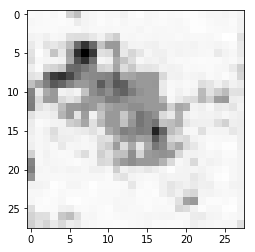

Estimate: [[-3.0319326]]
Iteration: 1950 at 2019-06-07 15:56:41.099319


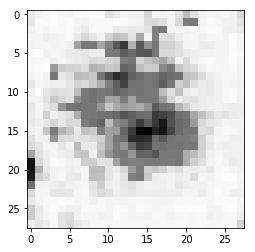

Estimate: [[-2.1583786]]
Iteration: 2000 at 2019-06-07 15:56:57.627817


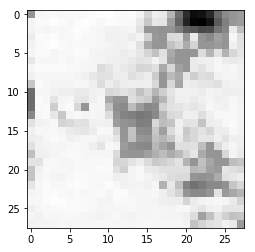

Estimate: [[-0.5715252]]
Iteration: 2050 at 2019-06-07 15:57:14.777567


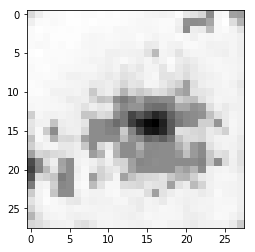

Estimate: [[-1.0452805]]
Iteration: 2100 at 2019-06-07 15:57:31.396826


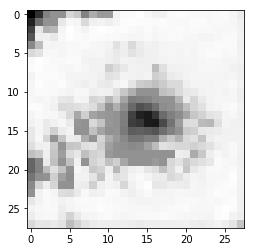

Estimate: [[0.4179785]]
Iteration: 2150 at 2019-06-07 15:57:47.958580


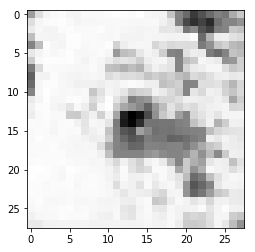

Estimate: [[-1.9624622]]
Iteration: 2200 at 2019-06-07 15:58:04.467614


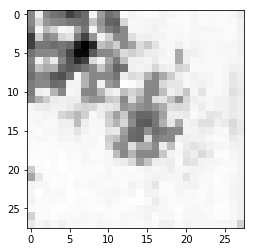

Estimate: [[-0.4593687]]
Iteration: 2250 at 2019-06-07 15:58:21.894264


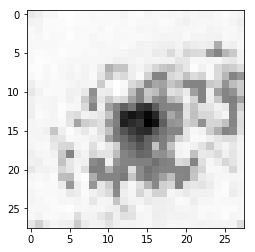

Estimate: [[-0.41211098]]
Iteration: 2300 at 2019-06-07 15:58:38.396686


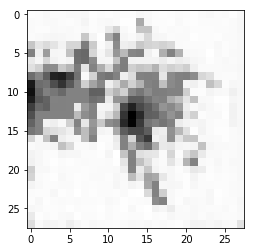

Estimate: [[0.64259416]]
Iteration: 2350 at 2019-06-07 15:58:55.172383


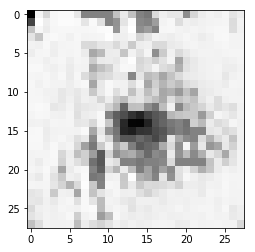

Estimate: [[-0.2968324]]
Iteration: 2400 at 2019-06-07 15:59:12.745464


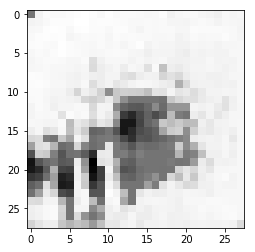

Estimate: [[-0.07811999]]
Iteration: 2450 at 2019-06-07 15:59:29.273754


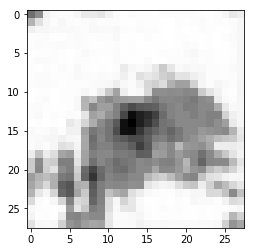

Estimate: [[-3.095171]]
Iteration: 2500 at 2019-06-07 15:59:46.164270


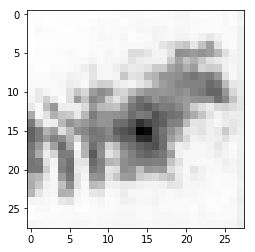

Estimate: [[0.8625358]]
Iteration: 2550 at 2019-06-07 16:00:03.052229


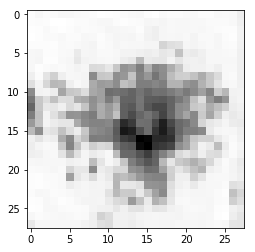

Estimate: [[0.04413104]]
Iteration: 2600 at 2019-06-07 16:00:19.941647


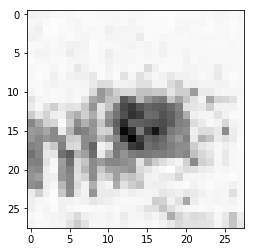

Estimate: [[0.12600982]]
Iteration: 2650 at 2019-06-07 16:00:36.632271


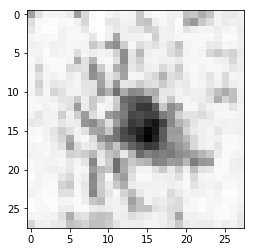

Estimate: [[-0.39055866]]
Iteration: 2700 at 2019-06-07 16:00:53.455043


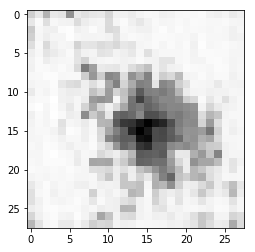

Estimate: [[-0.2662959]]
Iteration: 2750 at 2019-06-07 16:01:10.834779


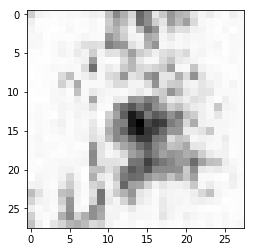

Estimate: [[0.40106145]]
Iteration: 2800 at 2019-06-07 16:01:27.449482


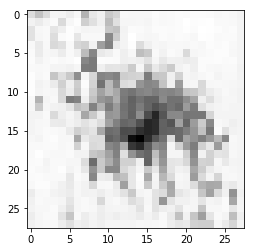

Estimate: [[-0.09348264]]
Iteration: 2850 at 2019-06-07 16:01:44.047829


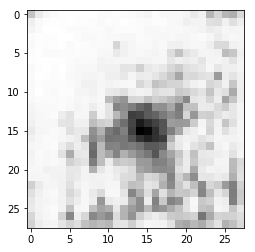

Estimate: [[-0.2491143]]
Iteration: 2900 at 2019-06-07 16:02:00.720580


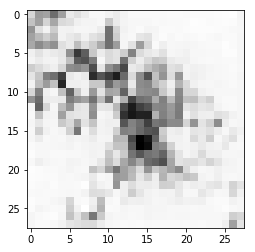

Estimate: [[0.6617434]]
Iteration: 2950 at 2019-06-07 16:02:17.380744


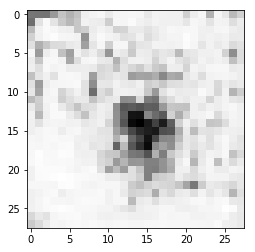

Estimate: [[-0.6462837]]
Iteration: 3000 at 2019-06-07 16:02:34.013460


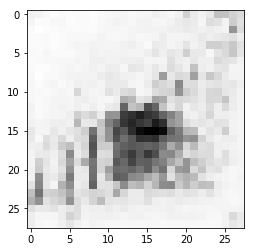

Estimate: [[-0.23623237]]
Iteration: 3050 at 2019-06-07 16:02:50.765462


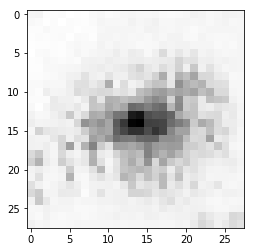

Estimate: [[0.0793106]]
Iteration: 3100 at 2019-06-07 16:03:07.962402


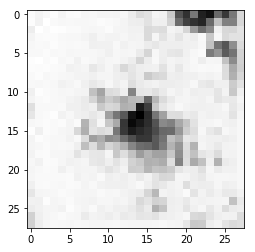

Estimate: [[0.70822406]]
Iteration: 3150 at 2019-06-07 16:03:24.685759


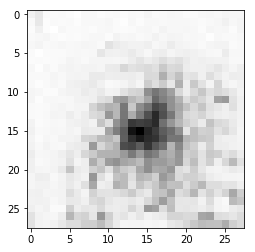

Estimate: [[0.27481577]]
Iteration: 3200 at 2019-06-07 16:03:41.504271


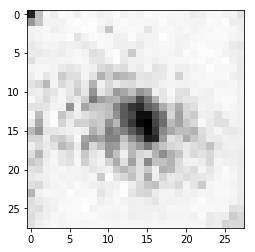

Estimate: [[0.90908206]]
Iteration: 3250 at 2019-06-07 16:03:58.178372


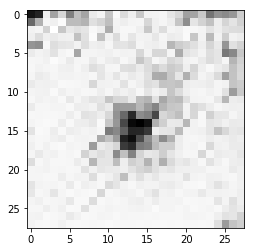

Estimate: [[0.46862912]]
Iteration: 3300 at 2019-06-07 16:04:15.192080


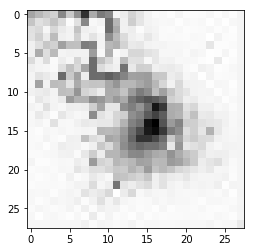

Estimate: [[1.31143]]
Iteration: 3350 at 2019-06-07 16:04:31.873968


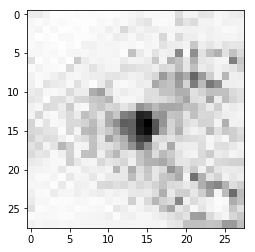

Estimate: [[0.15782267]]
Iteration: 3400 at 2019-06-07 16:04:48.536973


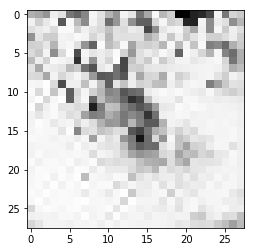

Estimate: [[1.0567104]]
Iteration: 3450 at 2019-06-07 16:05:05.783865


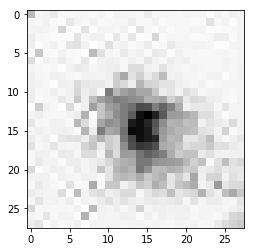

Estimate: [[1.2417758]]
Iteration: 3500 at 2019-06-07 16:05:22.740596


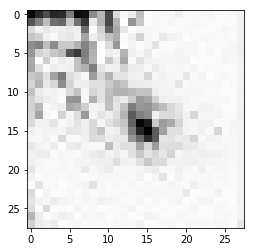

Estimate: [[2.2812302]]
Iteration: 3550 at 2019-06-07 16:05:39.506234


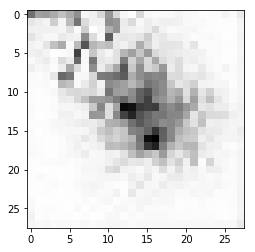

Estimate: [[1.2545803]]
Iteration: 3600 at 2019-06-07 16:05:56.380712


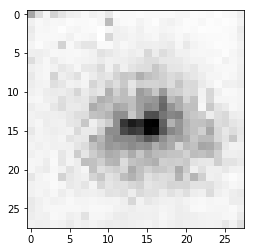

Estimate: [[0.2692434]]
Iteration: 3650 at 2019-06-07 16:06:13.042577


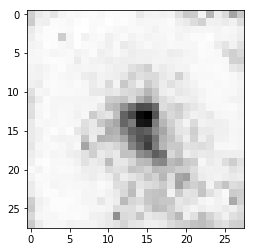

Estimate: [[0.6889858]]
Iteration: 3700 at 2019-06-07 16:06:29.691504


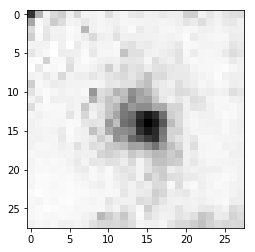

Estimate: [[0.68084455]]
Iteration: 3750 at 2019-06-07 16:06:46.559015


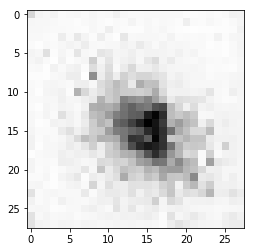

Estimate: [[1.0851719]]
Iteration: 3800 at 2019-06-07 16:07:03.317940


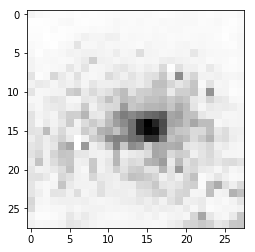

Estimate: [[0.84033823]]
Iteration: 3850 at 2019-06-07 16:07:20.587280


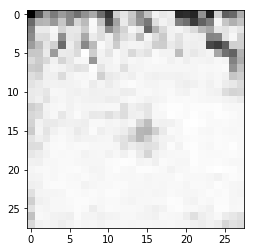

Estimate: [[1.4546866]]
Iteration: 3900 at 2019-06-07 16:07:37.442030


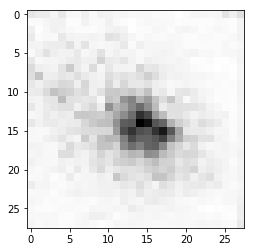

Estimate: [[0.5844857]]
Iteration: 3950 at 2019-06-07 16:07:54.123823


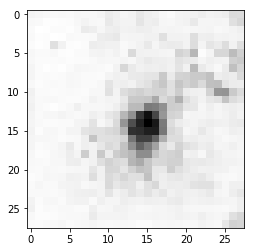

Estimate: [[0.55799204]]
Iteration: 4000 at 2019-06-07 16:08:10.914685


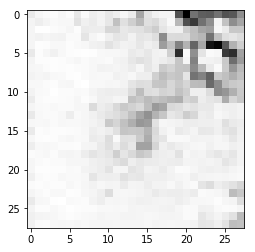

Estimate: [[1.2483083]]
Iteration: 4050 at 2019-06-07 16:08:27.412105


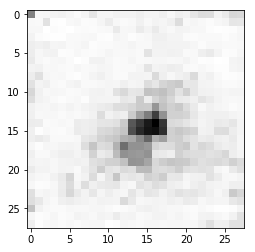

Estimate: [[0.2501688]]
Iteration: 4100 at 2019-06-07 16:08:44.044807


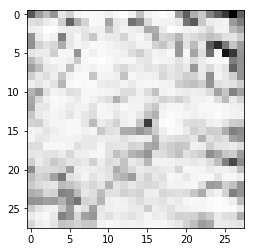

Estimate: [[0.62263405]]
Iteration: 4150 at 2019-06-07 16:09:01.420468


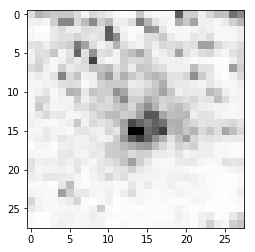

Estimate: [[0.94691294]]
Iteration: 4200 at 2019-06-07 16:09:21.401970


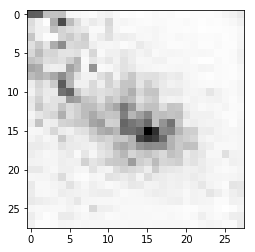

Estimate: [[1.2216673]]
Iteration: 4250 at 2019-06-07 16:09:42.004065


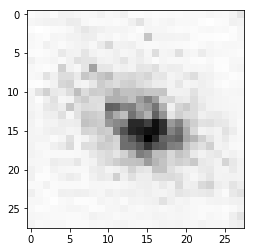

Estimate: [[0.6933068]]
Iteration: 4300 at 2019-06-07 16:09:58.976901


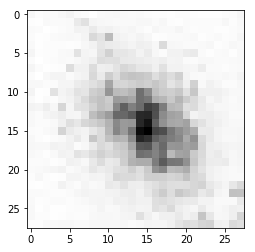

Estimate: [[1.3370663]]
Iteration: 4350 at 2019-06-07 16:10:16.260300


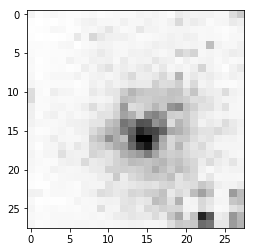

Estimate: [[0.9095117]]
Iteration: 4400 at 2019-06-07 16:10:33.896245


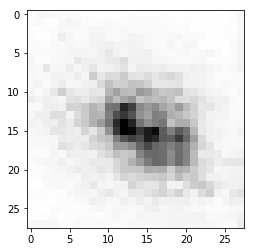

Estimate: [[1.5778929]]
Iteration: 4450 at 2019-06-07 16:10:55.844901


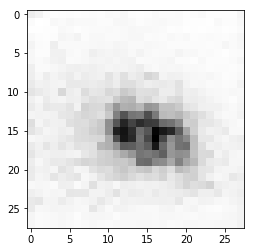

Estimate: [[1.1640968]]
Iteration: 4500 at 2019-06-07 16:11:14.755247


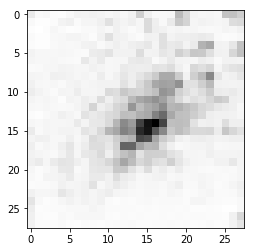

Estimate: [[1.7327545]]
Iteration: 4550 at 2019-06-07 16:11:33.194125


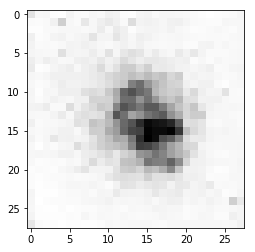

Estimate: [[1.365186]]
Iteration: 4600 at 2019-06-07 16:11:51.509476


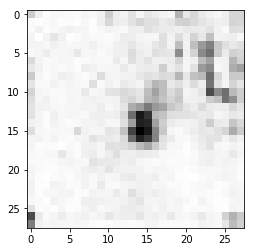

Estimate: [[1.0003572]]
Iteration: 4650 at 2019-06-07 16:12:09.977764


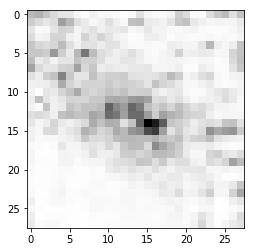

Estimate: [[1.1937368]]
Iteration: 4700 at 2019-06-07 16:12:28.288122


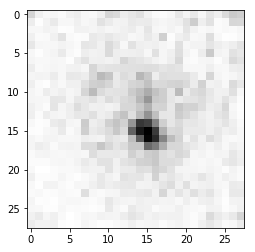

Estimate: [[0.7996088]]
Iteration: 4750 at 2019-06-07 16:12:47.003849


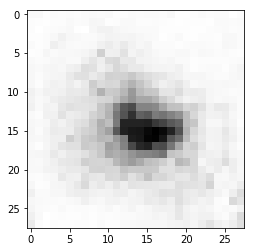

Estimate: [[1.5794852]]
Iteration: 4800 at 2019-06-07 16:13:04.766736


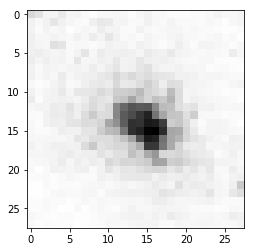

Estimate: [[0.8058629]]
Iteration: 4850 at 2019-06-07 16:13:23.183051


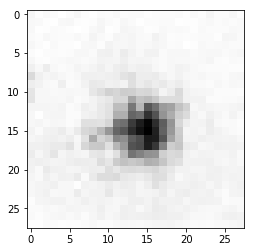

Estimate: [[1.0122108]]
Iteration: 4900 at 2019-06-07 16:13:41.280594


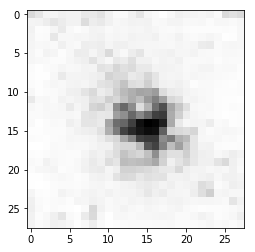

Estimate: [[0.6220914]]
Iteration: 4950 at 2019-06-07 16:13:59.363546


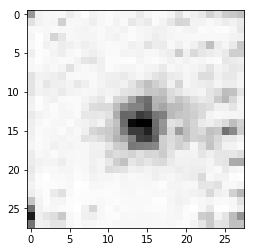

Estimate: [[1.0412264]]
Iteration: 5000 at 2019-06-07 16:14:17.748626


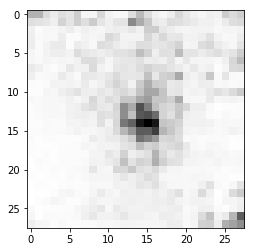

Estimate: [[1.5794458]]
Iteration: 5050 at 2019-06-07 16:14:35.678528


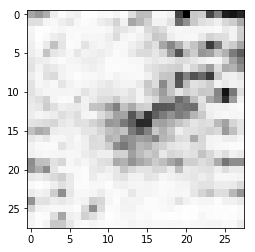

Estimate: [[1.3465703]]
Iteration: 5100 at 2019-06-07 16:14:59.815785


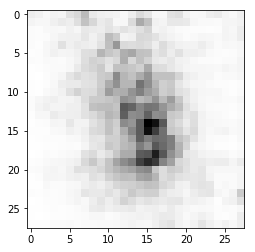

Estimate: [[1.6495092]]
Iteration: 5150 at 2019-06-07 16:15:19.180914


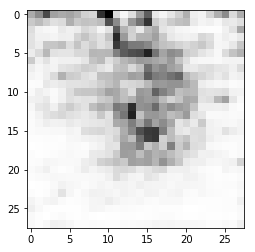

Estimate: [[1.2773508]]
Iteration: 5200 at 2019-06-07 16:15:36.815744


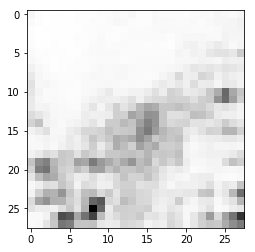

Estimate: [[1.4301584]]
Iteration: 5250 at 2019-06-07 16:15:55.306424


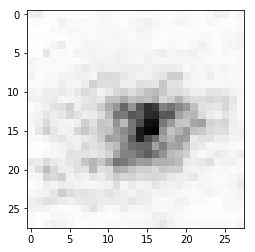

Estimate: [[1.1984184]]
Iteration: 5300 at 2019-06-07 16:16:13.573860


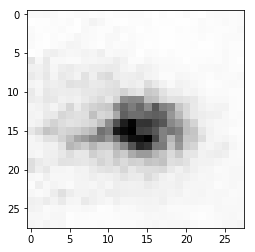

Estimate: [[1.3494773]]
Iteration: 5350 at 2019-06-07 16:16:31.840109


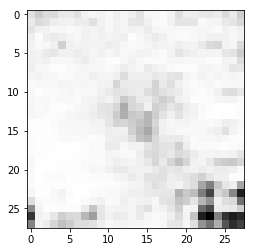

Estimate: [[1.0650918]]
Iteration: 5400 at 2019-06-07 16:16:49.006200


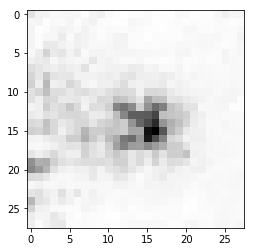

Estimate: [[2.2848914]]
Iteration: 5450 at 2019-06-07 16:17:07.545235


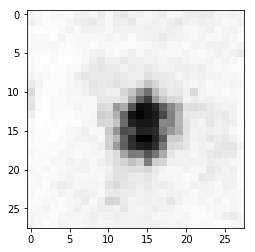

Estimate: [[1.0405796]]
Iteration: 5500 at 2019-06-07 16:17:25.020046


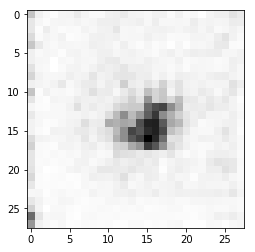

Estimate: [[1.4187691]]
Iteration: 5550 at 2019-06-07 16:17:41.906473


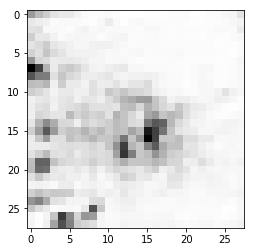

Estimate: [[1.3353934]]
Iteration: 5600 at 2019-06-07 16:17:58.645038


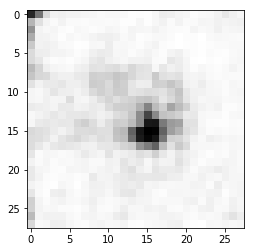

Estimate: [[1.0155766]]
Iteration: 5650 at 2019-06-07 16:18:15.711172


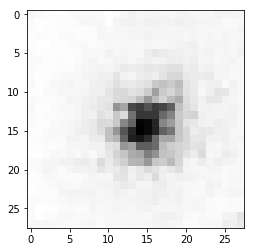

Estimate: [[1.2946253]]
Iteration: 5700 at 2019-06-07 16:18:32.482242


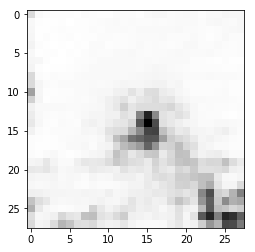

Estimate: [[1.2486064]]
Iteration: 5750 at 2019-06-07 16:18:49.414500


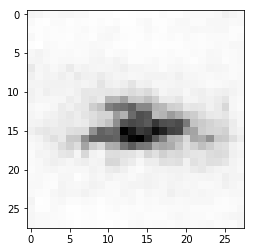

Estimate: [[1.5114455]]
Iteration: 5800 at 2019-06-07 16:19:06.493691


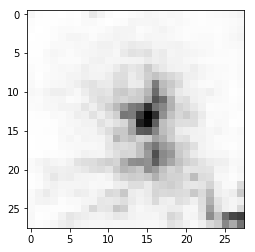

Estimate: [[1.1505029]]
Iteration: 5850 at 2019-06-07 16:19:24.601929


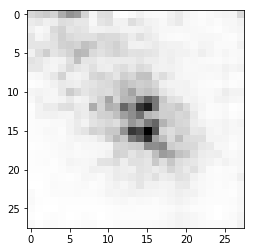

Estimate: [[1.5630221]]
Iteration: 5900 at 2019-06-07 16:19:41.653459


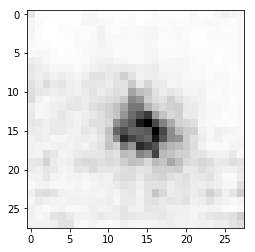

Estimate: [[1.1679165]]
Iteration: 5950 at 2019-06-07 16:20:02.265010


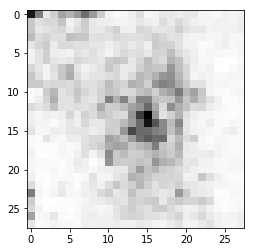

Estimate: [[1.2094667]]
Iteration: 6000 at 2019-06-07 16:20:20.653308


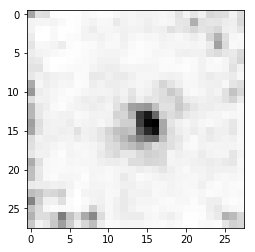

Estimate: [[1.181871]]
Iteration: 6050 at 2019-06-07 16:20:38.699179


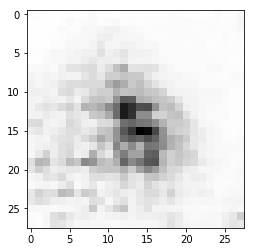

Estimate: [[1.215715]]
Iteration: 6100 at 2019-06-07 16:20:57.536293


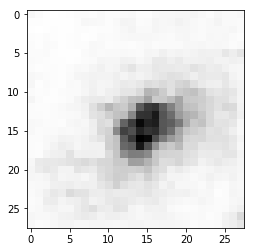

Estimate: [[2.0977128]]
Iteration: 6150 at 2019-06-07 16:21:16.346531


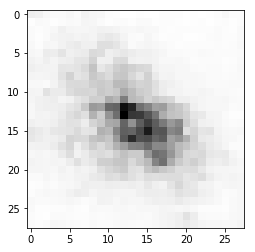

Estimate: [[1.5778018]]
Iteration: 6200 at 2019-06-07 16:21:34.475149


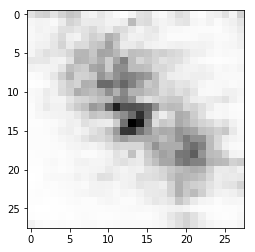

Estimate: [[1.361131]]
Iteration: 6250 at 2019-06-07 16:21:53.194791


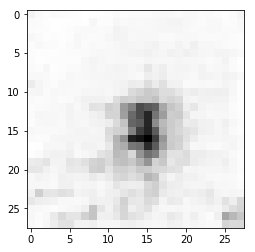

Estimate: [[1.6832873]]
Iteration: 6300 at 2019-06-07 16:22:11.357473


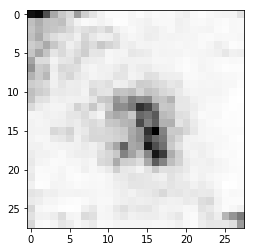

Estimate: [[1.3254809]]
Iteration: 6350 at 2019-06-07 16:22:30.162682


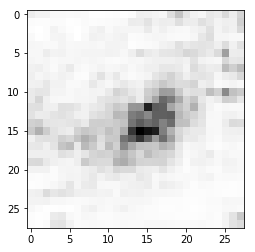

Estimate: [[1.012178]]
Iteration: 6400 at 2019-06-07 16:22:48.856997


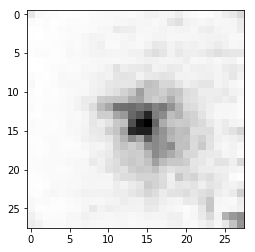

Estimate: [[1.8009888]]
Iteration: 6450 at 2019-06-07 16:23:07.684101


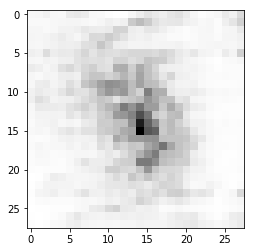

Estimate: [[1.4646902]]
Iteration: 6500 at 2019-06-07 16:23:26.408374


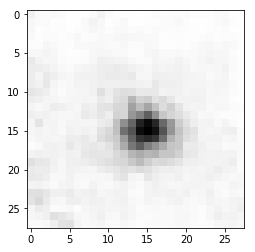

Estimate: [[1.2649046]]
Iteration: 6550 at 2019-06-07 16:23:44.968259


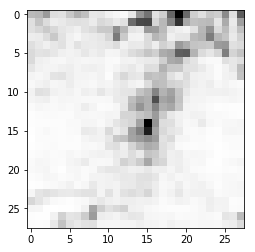

Estimate: [[1.3126942]]
Iteration: 6600 at 2019-06-07 16:24:03.344011


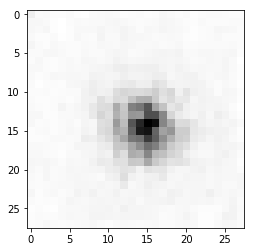

Estimate: [[1.7263346]]
Iteration: 6650 at 2019-06-07 16:24:22.884138


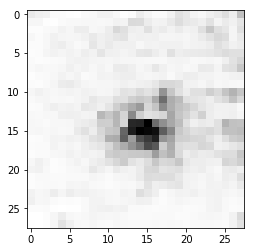

Estimate: [[1.7099704]]
Iteration: 6700 at 2019-06-07 16:24:41.432417


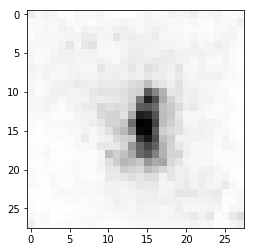

Estimate: [[1.3201405]]
Iteration: 6750 at 2019-06-07 16:25:00.072803


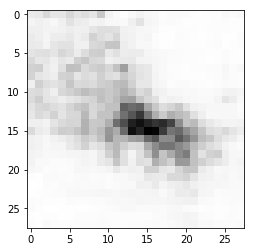

Estimate: [[2.27658]]
Iteration: 6800 at 2019-06-07 16:25:22.836872


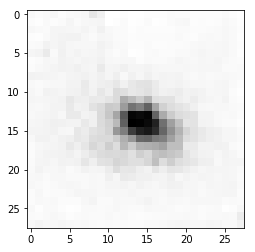

Estimate: [[1.7252772]]
Iteration: 6850 at 2019-06-07 16:25:44.332472


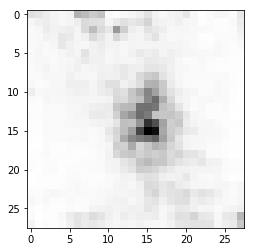

Estimate: [[1.4410138]]
Iteration: 6900 at 2019-06-07 16:26:04.325151


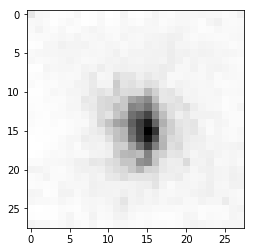

Estimate: [[1.7953012]]
Iteration: 6950 at 2019-06-07 16:26:22.652993


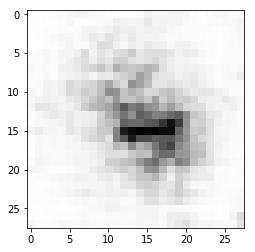

Estimate: [[1.6776711]]
Iteration: 7000 at 2019-06-07 16:26:43.783894


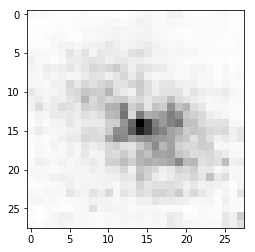

Estimate: [[1.2731203]]
Iteration: 7050 at 2019-06-07 16:27:06.091295


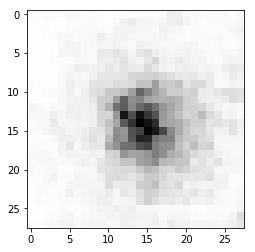

Estimate: [[1.828264]]
Iteration: 7100 at 2019-06-07 16:27:25.744208


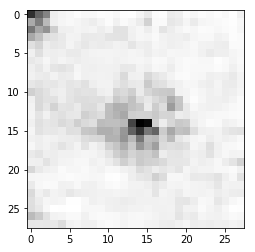

Estimate: [[1.1366913]]
Iteration: 7150 at 2019-06-07 16:27:44.464579


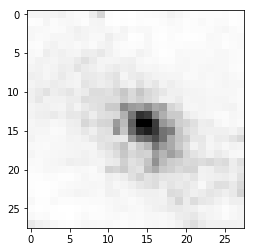

Estimate: [[1.8133609]]
Iteration: 7200 at 2019-06-07 16:28:02.981568


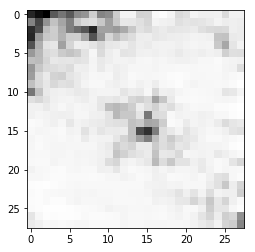

Estimate: [[0.8362339]]
Iteration: 7250 at 2019-06-07 16:28:21.892317


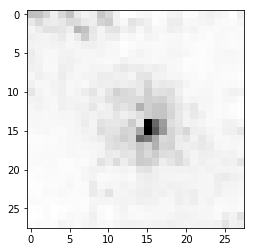

Estimate: [[1.723217]]
Iteration: 7300 at 2019-06-07 16:28:43.150702


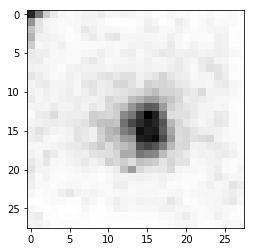

Estimate: [[1.3575944]]
Iteration: 7350 at 2019-06-07 16:29:02.854285


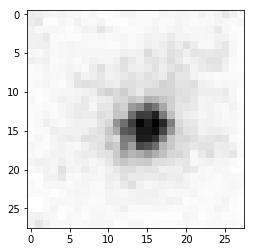

Estimate: [[1.5598058]]
Iteration: 7400 at 2019-06-07 16:29:23.000860


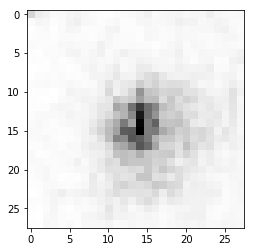

Estimate: [[2.203406]]
Iteration: 7450 at 2019-06-07 16:29:42.459127


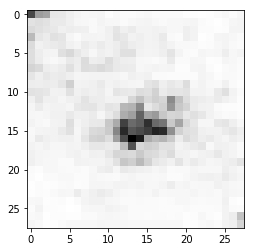

Estimate: [[1.1599159]]
Iteration: 7500 at 2019-06-07 16:30:01.285152


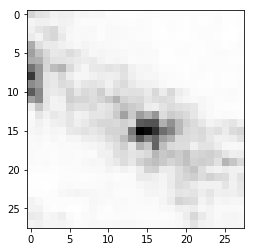

Estimate: [[2.3153095]]
Iteration: 7550 at 2019-06-07 16:30:20.175305


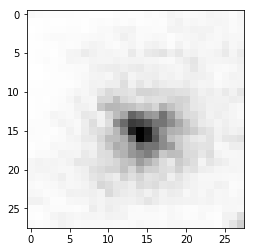

Estimate: [[1.3083813]]
Iteration: 7600 at 2019-06-07 16:30:39.065805


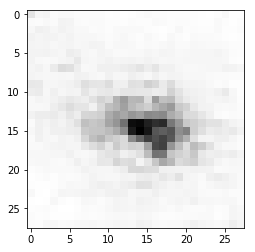

Estimate: [[1.2423413]]
Iteration: 7650 at 2019-06-07 16:30:58.440505


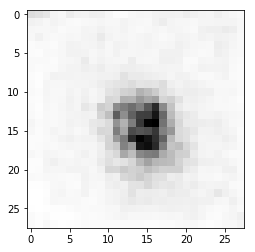

Estimate: [[1.9463878]]
Iteration: 7700 at 2019-06-07 16:31:17.349135


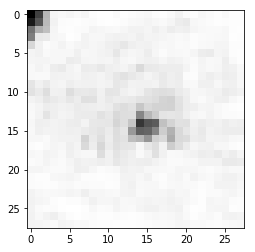

Estimate: [[2.0146704]]
Iteration: 7750 at 2019-06-07 16:31:35.731011


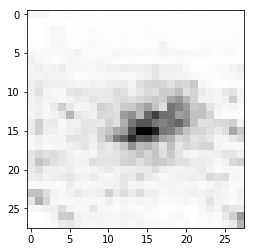

Estimate: [[1.08856]]
Iteration: 7800 at 2019-06-07 16:31:53.987311


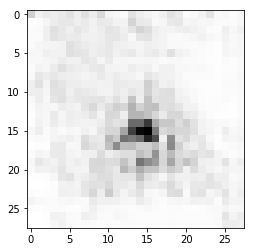

Estimate: [[1.8557492]]
Iteration: 7850 at 2019-06-07 16:32:13.748048


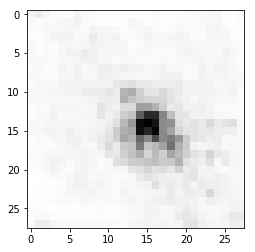

Estimate: [[1.5902092]]
Iteration: 7900 at 2019-06-07 16:32:32.810990


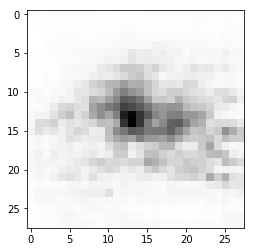

Estimate: [[0.9377975]]
Iteration: 7950 at 2019-06-07 16:32:51.483542


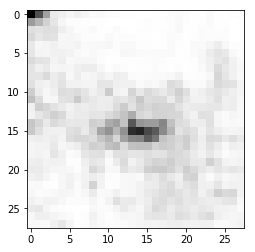

Estimate: [[2.046507]]
Iteration: 8000 at 2019-06-07 16:33:09.974570


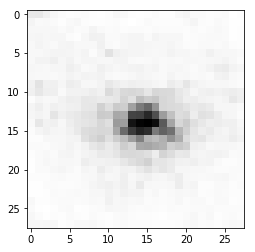

Estimate: [[1.8318348]]
Iteration: 8050 at 2019-06-07 16:33:29.383452


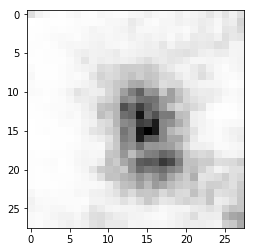

Estimate: [[2.194316]]
Iteration: 8100 at 2019-06-07 16:33:48.542550


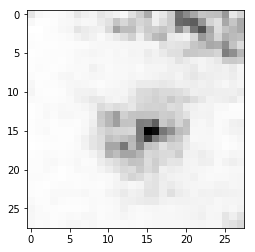

Estimate: [[1.1145557]]
Iteration: 8150 at 2019-06-07 16:34:06.662775


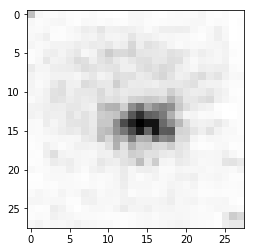

Estimate: [[1.7428454]]
Iteration: 8200 at 2019-06-07 16:34:28.659243


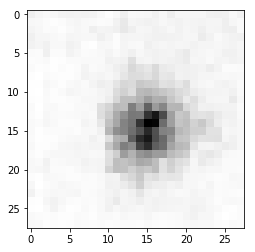

Estimate: [[1.5397719]]
Iteration: 8250 at 2019-06-07 16:34:47.476646


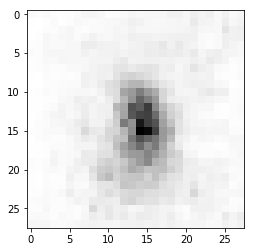

Estimate: [[2.1472528]]
Iteration: 8300 at 2019-06-07 16:35:05.808920


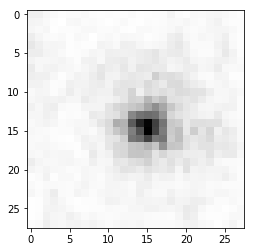

Estimate: [[2.410632]]
Iteration: 8350 at 2019-06-07 16:35:25.573480


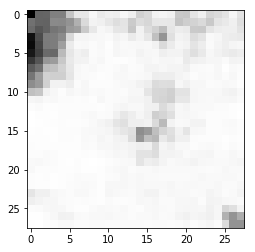

Estimate: [[4.5600595]]
Iteration: 8400 at 2019-06-07 16:35:47.077501


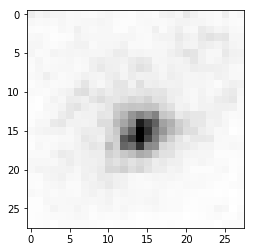

Estimate: [[1.2024122]]
Iteration: 8450 at 2019-06-07 16:36:06.858174


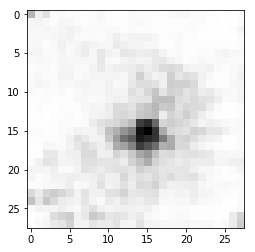

Estimate: [[1.4297748]]
Iteration: 8500 at 2019-06-07 16:36:25.269780


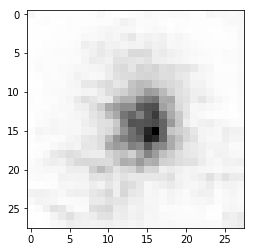

Estimate: [[1.717874]]
Iteration: 8550 at 2019-06-07 16:36:43.810733


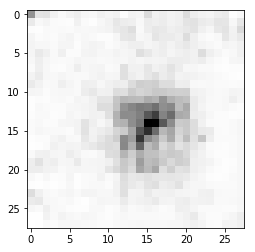

Estimate: [[1.7233895]]
Iteration: 8600 at 2019-06-07 16:37:04.080604


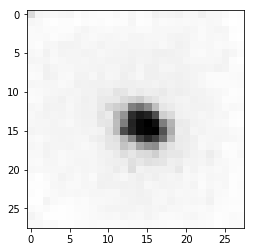

Estimate: [[2.7930362]]
Iteration: 8650 at 2019-06-07 16:37:24.371166


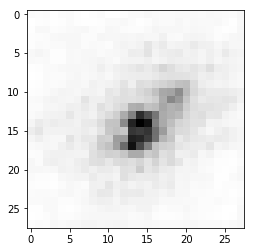

Estimate: [[1.6268746]]
Iteration: 8700 at 2019-06-07 16:37:43.319180


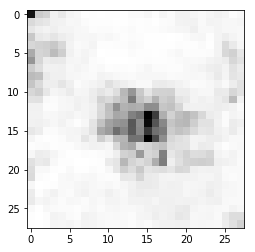

Estimate: [[1.8537555]]
Iteration: 8750 at 2019-06-07 16:38:01.329636


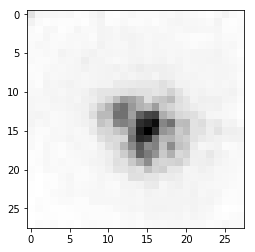

Estimate: [[1.3719417]]
Iteration: 8800 at 2019-06-07 16:38:19.186488


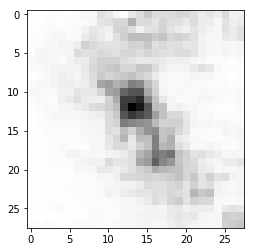

Estimate: [[0.47986808]]
Iteration: 8850 at 2019-06-07 16:38:37.071135


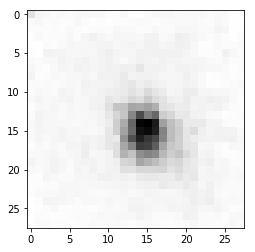

Estimate: [[2.2827003]]
Iteration: 8900 at 2019-06-07 16:38:56.037322


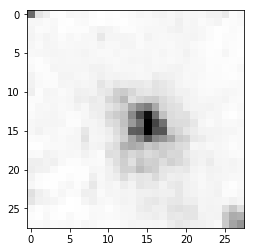

Estimate: [[0.93371475]]
Iteration: 8950 at 2019-06-07 16:39:16.476799


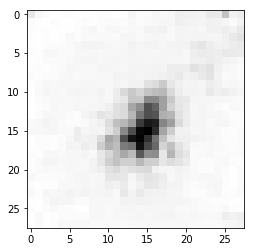

Estimate: [[1.1119864]]
Iteration: 9000 at 2019-06-07 16:39:35.068438


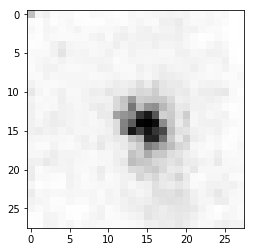

Estimate: [[1.0675558]]
Iteration: 9050 at 2019-06-07 16:39:55.452348


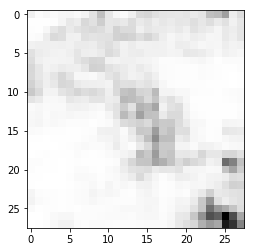

Estimate: [[3.4272766]]
Iteration: 9100 at 2019-06-07 16:40:14.333660


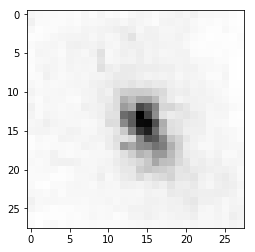

Estimate: [[2.449683]]
Iteration: 9150 at 2019-06-07 16:40:32.324213


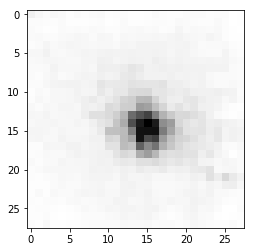

Estimate: [[1.0447917]]
Iteration: 9200 at 2019-06-07 16:40:51.329396


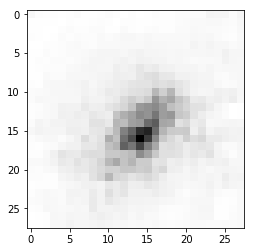

Estimate: [[1.6216345]]
Iteration: 9250 at 2019-06-07 16:41:10.603188


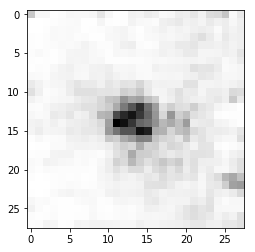

Estimate: [[1.2690774]]
Iteration: 9300 at 2019-06-07 16:41:30.352941


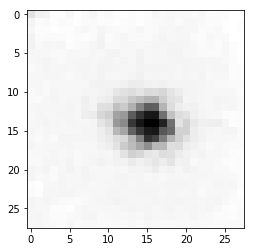

Estimate: [[1.6447037]]
Iteration: 9350 at 2019-06-07 16:41:49.341886


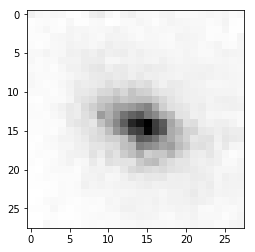

Estimate: [[1.7694801]]
Iteration: 9400 at 2019-06-07 16:42:08.224504


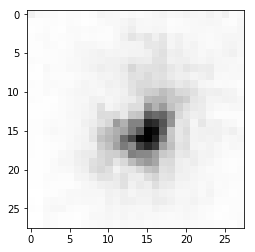

Estimate: [[1.2681379]]
Iteration: 9450 at 2019-06-07 16:42:26.623787


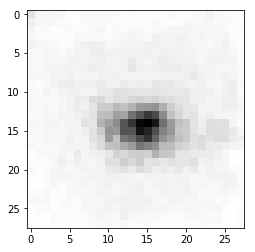

Estimate: [[1.2686102]]
Iteration: 9500 at 2019-06-07 16:42:44.744751


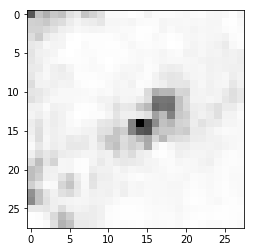

Estimate: [[3.1000416]]
Iteration: 9550 at 2019-06-07 16:43:02.913387


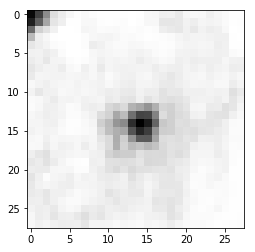

Estimate: [[1.0062898]]
Iteration: 9600 at 2019-06-07 16:43:21.289879


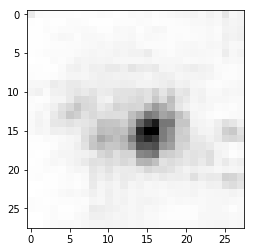

Estimate: [[1.4736578]]
Iteration: 9650 at 2019-06-07 16:43:39.694266


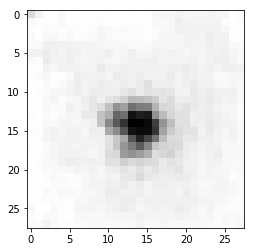

Estimate: [[0.99697983]]
Iteration: 9700 at 2019-06-07 16:43:59.862327


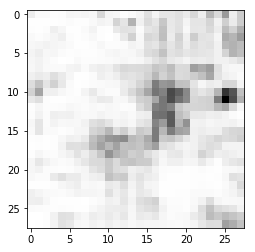

Estimate: [[1.2479426]]
Iteration: 9750 at 2019-06-07 16:44:19.537860


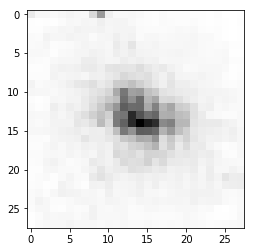

Estimate: [[1.6101559]]
Iteration: 9800 at 2019-06-07 16:44:38.733940


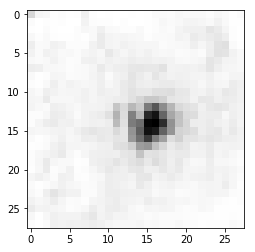

Estimate: [[1.4566646]]
Iteration: 9850 at 2019-06-07 16:44:58.377671


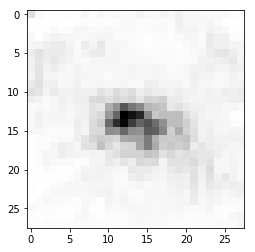

Estimate: [[1.9145939]]
Iteration: 9900 at 2019-06-07 16:45:16.905465


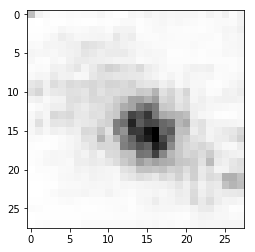

Estimate: [[0.92619735]]
Iteration: 9950 at 2019-06-07 16:45:35.838025


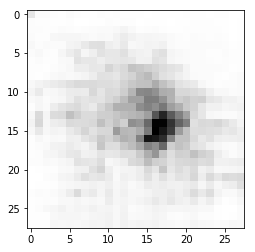

Estimate: [[0.81446946]]


In [11]:
tf.get_variable_scope().reuse_variables()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28,28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(10000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28,28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})


    if i % 50 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28,28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)